In [2]:
import functions as mf
import functions_axis_symmetric as mfa
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

import importlib
importlib.reload(mf)
importlib.reload(mfa)

<module 'functions_axis_symmetric' from 'c:\\Users\\brent\\Documents\\comp_multphase_flow\\functions_axis_symmetric.py'>

In [79]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.1

y_end = 5e-3 # m

angle = 0#np.pi / 2

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
# mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system

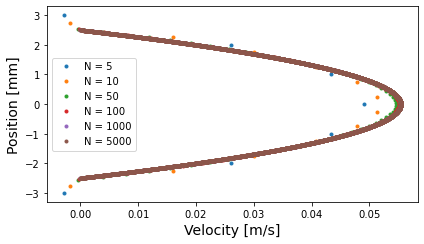

In [18]:
def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
        pressure_boundary, boundary_condition, mu_plasma, angle)
    return system         

#4 Prescribed flow rate
Ny = 1000
N_range = [5, 10, 50, 100, 1000, 5000]
# N_range = [1000, 5000, 20000]
plt.figure(figsize=(6,3.5))

for Ny in N_range:
    rho_plasma = 1003 #  kg/m3
    mu_plasma = 1e-3 # kg/ms

    rho_RBC = 1096 # kg/m3
    diameter_RBC = 8e-6 # m
    volume_fraction_RBC = 0.1

    y_end = 5e-3 # m

    angle = np.pi / 2

    boundary_condition = [1, 1] 
    blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
    Q_des = 185*1e-6 #m3/s total bloodflow
    pressure_difference = 1e-3
    pressure_boundary = np.array([1, 1])*1e-3
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                        pressure_boundary, boundary_condition, mu_plasma, angle)
    mu = system.calc_mu(mu_plasma)

    system = reloadsystem()
    # Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
    eps = 1e-3
    error = 1
    system.set_pressure_difference(pressure_difference)

    velocity = system.simulate(mu)
    Q = np.trapz(velocity, x=system.y)
    factor = 0.95
    #P = [system.pressure_difference, 2*system.pressure_difference]
    switch = [0,0]

    while error > eps:
    # for i in range(1):
        if switch[-2] != switch[-1]:
            factor*=0.9
        if Q<Q_des:
            # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
            system.pressure_difference += system.pressure_difference * factor

            velocity = system.simulate(mu)
            Q = np.trapz(velocity, x=system.y)
            error = np.abs((Q-Q_des)/Q_des)
            switch.append(0)
            # P.append(system.pressure_difference)
        else:
            # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
            system.pressure_difference -= system.pressure_difference * factor
            velocity = system.simulate(mu)
            Q = np.trapz(velocity, x=system.y)
            error = np.abs((Q-Q_des)/Q_des)
            # P.append(system.pressure_difference)
            switch.append(1)
        if len(switch) == 3000:
            print("Oh nyo, it's bwoken")
            break
    velocity_laminar = velocity
    mu_laminar = mu

    plt.plot(velocity, system.y * 1e3,  ".", label= 'N = {}'.format(Ny))

plt.xlabel("Velocity [m/s]", fontsize=14)
plt.ylabel("Position [mm]", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Laminar.svg")
plt.show()

53
0.00018491037999106798 0.000185


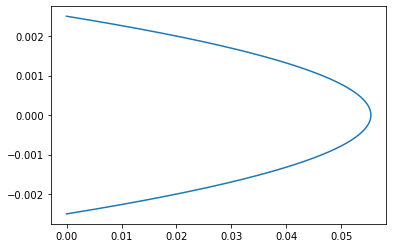

In [80]:
# Prescribed flow rate
Ny = 1000
system = reloadsystem()
mu = system.calc_mu(mu_plasma)
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

## Brentl Mixing Length

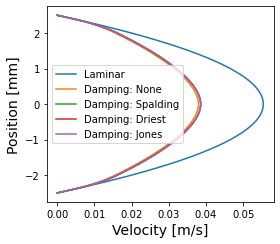

In [81]:


argument_types = [None, 'Spalding', 'Driest', 'Jones']

velocity_new = velocity_laminar

plt.figure(figsize=(4,3.5))
plt.plot(velocity_laminar, system.y * 1e3, label="Laminar")

for argument_type in argument_types:
    # Then calculate the solution with Prandtl mixing length
    eps = 0.01
    error = 1
    i = 0

    # Looping till solution converges
    while error > eps:
        velocity = velocity_new

        # Calculate new effective viscosity
        mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

        # Calculate ensuing velocity
        velocity_new = system.simulate(mu_Prandtl)

        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        print("iteration", i, "with error", error, end='\r')

        if i > 2000:
            print("Oh nyo, it's bwoken")
            break

    velocity_turbulent = velocity_new
    mu_turbulent = mu_Prandtl

    
    plt.plot(velocity_turbulent, system.y * 1e3, label="Damping: {}".format(argument_type))



plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Prandt_Mixing_lengths.svg")

plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_turbulent)
# plt.xscale("log")

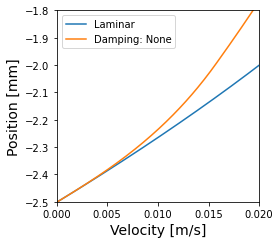

In [82]:


argument_types = [None]

velocity_new = velocity_laminar

plt.figure(figsize=(4,3.5))
plt.plot(velocity_laminar, system.y*1e3, label="Laminar")

for argument_type in argument_types:
    # Then calculate the solution with Prandtl mixing length
    eps = 0.01
    error = 1
    i = 0

    # Looping till solution converges
    while error > eps:
        velocity = velocity_new

        # Calculate new effective viscosity
        mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

        # Calculate ensuing velocity
        velocity_new = system.simulate(mu_Prandtl)

        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        print("iteration", i, "with error", error, end='\r')

        if i > 2000:
            print("Oh nyo, it's bwoken")
            break

    velocity_turbulent = velocity_new
    mu_turbulent = mu_Prandtl

    
    plt.plot(velocity_turbulent, system.y*1e3, label="Damping: {}".format(argument_type))



plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.xlim(0,0.02)
plt.ylim(-2.5,-1.8 )
# plt.xlim(0.035, 0.04)
plt.legend(fontsize=10)
plt.tight_layout()

# plt.savefig("Images/Prandt_Mixing_lengths_zoom.svg")
plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_turbulent)
# plt.xscale("log")

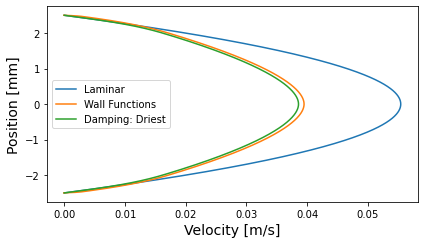

In [52]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl


# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_Driest)
# plt.xscale("log")


# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(E * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

plt.figure(figsize=(6,3.5))

# print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_laminar, system.y*1e3, label='Laminar')
plt.plot(velocity_new, system.y*1e3, label="Wall Functions")
plt.plot(velocity_Driest, system.y*1e3, label="Damping: Driest")

plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Functions_vs_Prandtl.svg")

plt.legend()
plt.show()

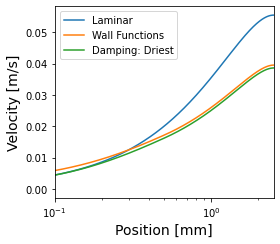

In [53]:
plt.figure(figsize=(4,3.5))

# print("iteration", i, "with error", error, end='\n')
plt.plot(system.y*1e3 + 2.5 + system.dy, velocity_laminar, label='Laminar')
plt.plot(system.y*1e3 + 2.5+ system.dy, velocity_new, label="Wall Functions")
plt.plot(system.y*1e3 + 2.5+ system.dy, velocity_Driest, label="Damping: Driest")
plt.xscale("log")

plt.ylabel('Velocity [m/s]', fontsize=14)
plt.xlabel('Position [mm]', fontsize=14)
plt.xlim(1e-1, 2.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Functions_vs_Prandtl_Loglaw.svg")

plt.show()

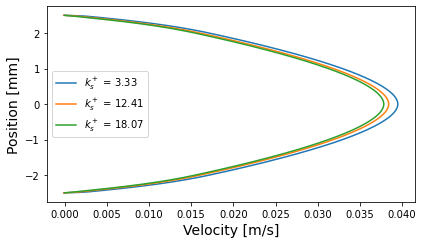

In [74]:
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
kss = np.array([ 10, 40, 75]) * system.nu_0
plt.figure(figsize=(6,3.5))

for ks in kss:

    i = 0
    error = 1
    epsilon = 1e-5
    while error > epsilon:
        velocity = velocity_new

        # Calculate the new y_plus
        tau_wall = velocity[1] / system.y_wall[1]
        u_tau = np.sqrt(tau_wall / system.rho)
        nu_0 = (mu_turbulent / system.rho)
        y_plus = system.y_wall * u_tau / nu_0

        # Calculate new wall roughness
        ks_plus = u_tau * ks / nu_0[1]
        wall_roughness = 32.6 / ks_plus

        
        # Add new nu for at wall
        nu_plus = np.zeros(system.Ny+2)
        mask = (y_plus < 11.25) * (y_plus > 0)
        nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
        nu = nu_0 + nu_plus
        mu = nu * system.rho

        # Calculate new velocity
        velocity_new = system.simulate(mu)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        # print("iteration", i, "with error", error, end='\r')

        if i > 200:
            print("Oh nyo, it's bwoken")
            break
    ks_plus = ks_plus.round(2)
    plt.plot(velocity_new, system.y*1e3, label=r'$k_s^+$ = {}'.format(ks_plus))

plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Roughness.svg")

plt.show()

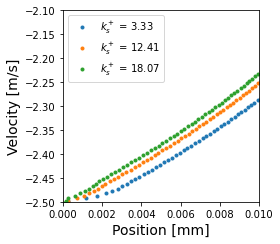

In [83]:
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
kss = np.array([ 10, 40, 75]) * system.nu_0
plt.figure(figsize=(4,3.5))

for ks in kss:

    i = 0
    error = 1
    epsilon = 1e-5
    while error > epsilon:
        velocity = velocity_new

        # Calculate the new y_plus
        tau_wall = velocity[1] / system.y_wall[1]
        u_tau = np.sqrt(tau_wall / system.rho)
        nu_0 = (mu_turbulent / system.rho)
        y_plus = system.y_wall * u_tau / nu_0

        # Calculate new wall roughness
        ks_plus = u_tau * ks / nu_0[1]
        wall_roughness = 32.6 / ks_plus

        
        # Add new nu for at wall
        nu_plus = np.zeros(system.Ny+2)
        mask = (y_plus < 11.25) * (y_plus > 0)
        nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
        nu = nu_0 + nu_plus
        mu = nu * system.rho

        # Calculate new velocity
        velocity_new = system.simulate(mu)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        # print("iteration", i, "with error", error, end='\r')

        if i > 200:
            print("Oh nyo, it's bwoken")
            break
    ks_plus = ks_plus.round(2)
    plt.plot(velocity_new, system.y*1e3,".", label=r'$k_s^+$ = {}'.format(ks_plus))

plt.ylabel('Velocity [m/s]', fontsize=14)
plt.xlabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.ylim(-2.5,-2.1 )
plt.tight_layout()
plt.savefig("Images/Wall_Roughness_zoomin.svg")

plt.show()

c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: divide by zero encountered in true_divide
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \
c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: invalid value encountered in multiply
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \


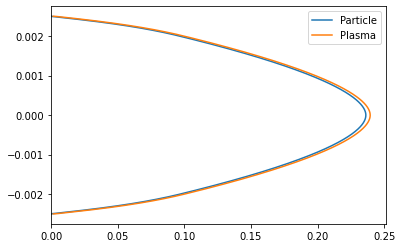

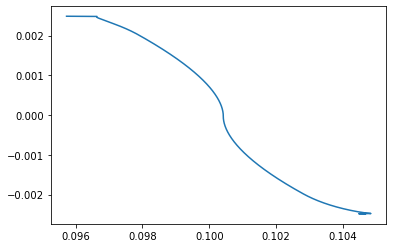

In [84]:
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break



velocity_turbulent = velocity_new
mu_turbulent = mu

# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_turbulent

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_turbulent, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

plt.plot(velocity_particle, system.y[1:-1],label="Particle")
plt.plot(velocity_plasma[1:-1], system.y[1:-1], label="Plasma")
plt.xlim(0)
plt.legend()
plt.show()
plt.plot(alpha_particles[alpha_particles != 0], system.y[alpha_particles != 0])
plt.show()

In [99]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 10960 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.1

y_end = 5e-3 # m
Ny = 1000
angle = np.pi / 2

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system


53
0.00018491037999106798 0.000185


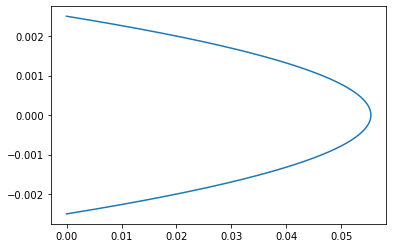

In [100]:
# Prescribed flow rate
system = reloadsystem()
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

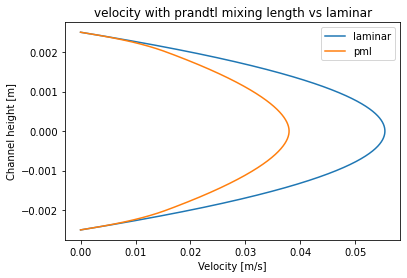

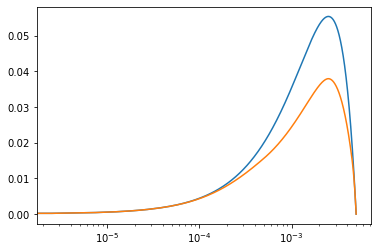

In [101]:
argument_type = None

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_turbulent, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_turbulent)
plt.xscale("log")

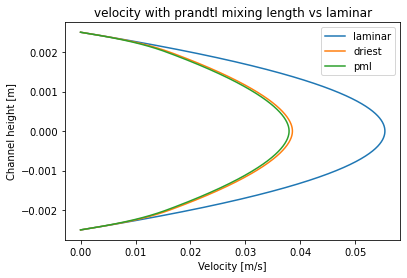

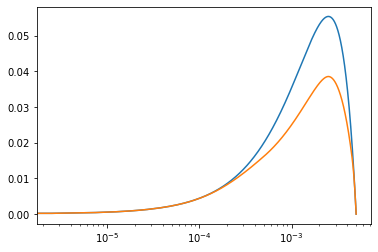

In [102]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_Driest, system.y, label="driest")
plt.plot(velocity_turbulent, system.y, label="pml")

plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()

# Check for log region
plt.plot(system.y + system.y_end / 2, velocity_laminar)
plt.plot(system.y + system.y_end / 2, velocity_Driest)
plt.xscale("log")

iteration 7 with error 6.104910721787788e-06


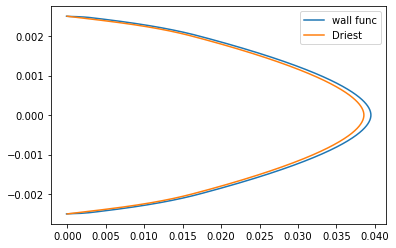

In [103]:
# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_new, system.y, label="wall func")
plt.plot(velocity_Driest, system.y, label="Driest")
plt.legend()
plt.show()

c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: divide by zero encountered in true_divide
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \
c:\Users\brent\Documents\comp_multphase_flow\functions.py:308: RuntimeWarning: invalid value encountered in multiply
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \


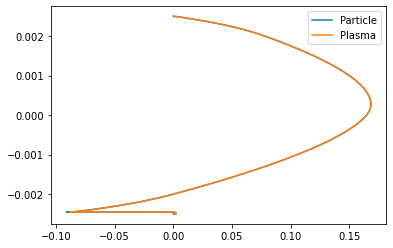

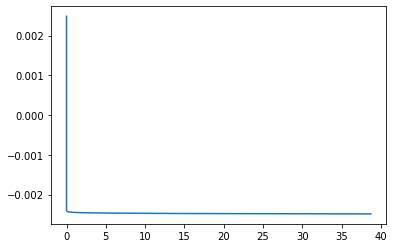

In [105]:
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_turbulent

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_turbulent, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

plt.plot(velocity_particle, system.y[1:-1],label="Particle")
plt.plot(velocity_plasma[1:-1], system.y[1:-1], label="Plasma")
# plt.xlim(-1e-9, 0)
plt.legend()
plt.show()
plt.plot(alpha_particles[alpha_particles != 0], system.y[alpha_particles != 0])
plt.show()